# Big Ideas in CS Final Project
# Team Plumber Pandas
# Project Plumbers Increasing Social Standing

In [1]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon, LineString, Point
from matplotlib import pyplot as plt

## First dataset: Where are the plumbers?

In [20]:
# import DataFrame
dataPlumbers = pd.read_csv("plumbers_employment.csv")

# make data usable for calculation
for neighborhood in dataPlumbers.index:
    population = int(dataPlumbers.iloc[neighborhood,2].replace(',', ''))
    percentPlumbers = str(dataPlumbers.iloc[neighborhood,7]).replace('%','')
    # perform calculation using population and percent of utility workers
    numPlumb = float(population) * (float(percentPlumbers)/100)
    # rewrite existing percentage as number of workers
    dataPlumbers.iloc[neighborhood,7] = numPlumb

dataPlumbers.rename(columns = {"Resident Jobs: Transportation, warehousing, utilities":"Plumbers"}, inplace=True)
dataPlumbers = dataPlumbers[["Neighborhood","Plumbers"]]
dataPlumbers.head(10)

,Neighborhood,Plumbers
0,Allegheny Center,0.0
1,Allegheny West,67.452
2,Allentown,140.0
3,Arlington,33.642
4,Arlington Heights,0.0
5,Banksville,78.736
6,Bedford Dwellings,147.846
7,Beechview,223.272
8,Beltzhoover,204.05
9,Bloomfield,151.956


Text(0, 0.5, 'Neighborhood')

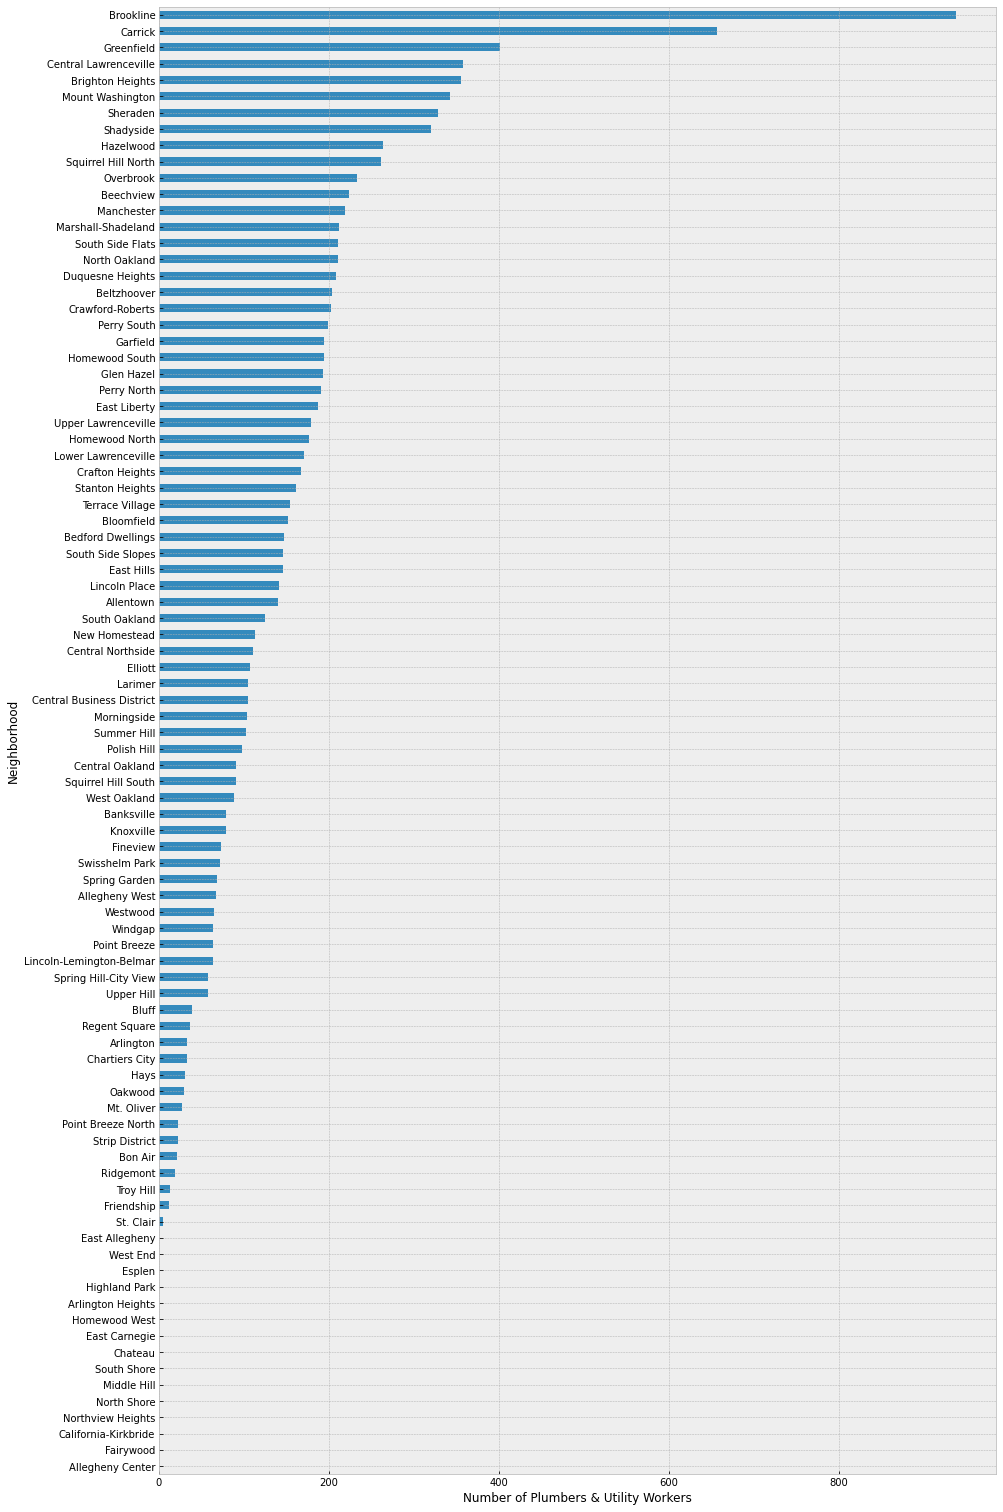

In [12]:
# graphing the DataFrame
dataPlumbers = dataPlumbers.sort_values(by=["Resident Jobs: Transportation, warehousing, utilities"], ascending=True)

graph = dataPlumbers.plot.barh(x="Neighborhood",y="Resident Jobs: Transportation, warehousing, utilities",figsize=(15,dataPlumbers.shape[0] * 0.3), legend=None)
graph.set_xlabel("Number of Plumbers & Utility Workers")
graph.set_ylabel("Neighborhood")

## Second dataset: Where can I find a water fountain?

In [11]:
dataPublicRestrooms = pd.read_csv('https://data.wprdc.org/datastore/dump/fbb50b02-2879-47cd-abea-ae697ec05170')

# import water features data
dataFountains = pd.read_csv("water-features.csv")

row_count = 0

#delete every row that is not a water fountain
for index, row in dataFountains.iterrows():
    if str(row[3]) != "Drinking Fountain":
        dataFountains = dataFountains.drop(labels=row_count, axis=0)
    row_count += 1

dataFountains.head()


,id,name,control_type,feature_type,inactive,make,image,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,1816791851,Able Long Park,Continuous,Drinking Fountain,f,Regular Fountain,https://tools.wprdc.org/images/pittsburgh/wate...,Beechview,4,19,42003192000,5,19,6,4-28,40.408440,-80.028330
1,1599892422,Albert Turk Graham Park,On/Off,Drinking Fountain,f,Most Dependable,https://tools.wprdc.org/images/pittsburgh/wate...,Crawford-Roberts,6,3,42003030500,3,3,2,2-1,40.440453,-79.984064
2,1422043278,Allegheny Commons Arch St,Continuous,Drinking Fountain,f,Regular Fountain,https://tools.wprdc.org/images/pittsburgh/wate...,Allegheny Center,1,22,42003562700,1,22,1,1-7,40.454390,-80.008281
3,1237191582,Allegheny Commons East Tennis Courts,Continuous,Drinking Fountain,f,Regular Fountain,https://tools.wprdc.org/images/pittsburgh/wate...,Allegheny Center,1,22,42003562700,1,22,1,1-6,40.450874,-80.001962
4,1146184773,Allegheny Commons Pool,Continuous,Drinking Fountain,f,Regular Fountain,https://tools.wprdc.org/images/pittsburgh/wate...,Allegheny Center,1,22,42003562700,1,22,1,1-6,40.451003,-80.001502


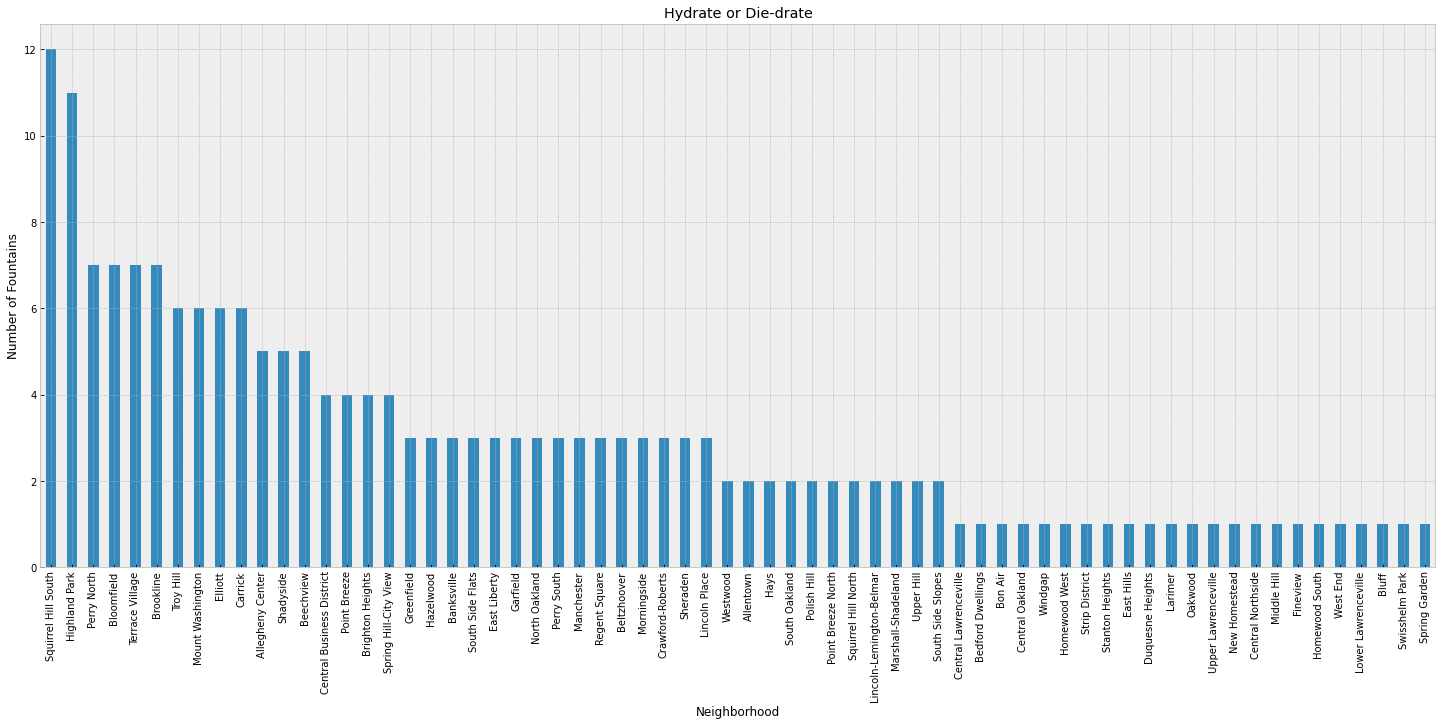

In [10]:
# sort list by neighborhood count, which will show num of fountains
numFountains = dataFountains['neighborhood'].value_counts().sort_values(ascending=False)

# graphing the DataFrame
plt.style.use("bmh")
numFountains.plot(kind="bar",figsize=(25,10),style="",ylabel="Number of Fountains",xlabel="Neighborhood",title="Hydrate or Die-drate")

## Third dataset: Fish fry

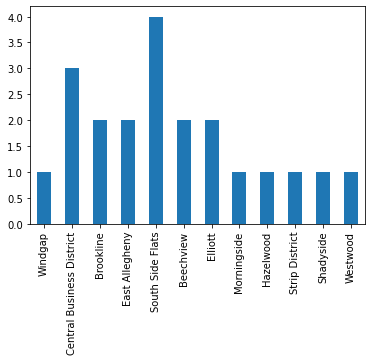

In [7]:
fishFryData = pd.read_csv('fishfry.csv')

# make dictionary
frypoints = dict()
lunchpoints = dict()
dataWaterFeatures = pd.read_csv('water-features.csv')

# make dictionary
dataPlumbers = pd.read_csv('plumbers_employment.csv')

# make dictionary
geoneighbor = gp.read_file('neighborhood.json')

neighborhoods = dataPlumbers['Neighborhood']

gs = gp.GeoDataFrame(geoneighbor)

for i,r in fishFryData.iterrows():
    lalo = Point(r['longitude'], r['latitude'])
    count = 0
    for p in gs.geometry:
        tf = lalo.within(p)
        if tf:
            n = geoneighbor['hood'][count]
            if n not in frypoints:
                frypoints[n] = 0
                lunchpoints[n] = 0
            if r['lunch']:
                lunchpoints[n] += 1
            frypoints[n] += 1
            break
        count+=1
fryd = pd.Series(frypoints)
fryd.sort_values(ascending=True)
lunchd = pd.Series(lunchpoints)
lunchd.sort_values(ascending=True)
fryd.plot(kind='bar')

# Conclusion

From this data, we can conclude that [] is the best neighborhood in Pittsburgh for a plumber to live, with lots of steady employment from the public fountains that might break down, and lots of fish fry for when you get hungry on the job.